In [1]:
# installing required packages
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin
!pip install meshio
!apt-get install gmsh
!gmsh --version
!pip install --upgrade gmsh

--2025-01-05 22:07:04--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4164 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.07K  --.-KB/s    in 0s      

2025-01-05 22:07:04 (33.3 MB/s) - ‘/tmp/fenics-install.sh’ saved [4164/4164]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/69e29b6f/releases/pybind11-ins

In [3]:
import gmsh, meshio
from fenics import *
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from dolfin import *
import numpy as np
# from mesh_converter import msh_to_xdmf

In [4]:
def msh_to_xdmf(filename: str, prune: bool = True):
    """a function to convert a gmsh .msh file to .xdmf to properly read it by dolfin

    :param (str) filename: the file name to read/write (not including extension). The extension ".msh" is
                           appended to create the 'read from' file name, and the extension ".xdmf" is appended
                           to create the 'write to' file name. If any mesh facets are marked as "Physical" regions,
                           the suffix "_facets.xdmf" is appended to create the file name for exporting this information.

    :param (bool) prune:Force the geometric dimension to match the topological dimension of the mesh by
                        removing geometry coordinates of higher dimension than the mesh topology (i.e. for 1D meshes,
                        only the x-coordinate is retained, for 2D meshes only the x- and y-coordinates are retained,
                        etc.)
    :return
    """
    # importing mesh from gmsh and defining surface and boundary markers
    msh = meshio.read(filename + ".msh")
    # determine mesh topological dimension
    if "tetra" in msh.cells_dict:
        tdim = 3
        cell_lbl = "tetra"
        facet_lbl = "triangle"
    elif "triangle" in msh.cells_dict:
        tdim = 2
        cell_lbl = "triangle"
        facet_lbl = "line"
    else:
        tdim = 1
        cell_lbl = "line"
        facet_lbl = "point"
    # extract node coordinates
    if prune:
        points = msh.points[:, :tdim]
    else:
        points = msh.points
    # extract cells and facets
    cells = msh.cells_dict[cell_lbl]
    if facet_lbl in msh.cells_dict:
        facets = msh.cells_dict[facet_lbl]
    else:
        facets = None
    # extract cell and facet markers
    if cell_lbl in msh.cell_data_dict["gmsh:physical"]:
        cell_data = msh.cell_data_dict["gmsh:physical"][cell_lbl]
    else:
        cell_data = None
    if facet_lbl in msh.cell_data_dict["gmsh:physical"]:
        facet_data = msh.cell_data_dict["gmsh:physical"][facet_lbl]
    else:
        facet_data = None

    cell_mesh = meshio.Mesh(
        points=points,
        cells={cell_lbl: cells},
        cell_data={"cell_marker": [cell_data]} if cell_data is not None else None,
    )
    meshio.write(filename + ".xdmf", cell_mesh)

    if facet_data is not None:
        facet_mesh = meshio.Mesh(
            points=points,
            cells={facet_lbl: facets},
            cell_data={"facet_marker": [facet_data]},
        )
        meshio.write(filename + "_facets.xdmf", facet_mesh)
    # all done
    return

In [5]:
def Tutorialmesh(Hmax, elementOrder, elementType):
    # Given Hmax, construct a mesh to be read by FEniCS
    gmsh.initialize()
    gmsh.model.add('Tutorialmesh')
    meshObject = gmsh.model

    # Points for the outer boundary
    point1 = meshObject.geo.addPoint(-1,-1,0,Hmax, 1)
    point2 = meshObject.geo.addPoint(1,-1,0,Hmax, 2)
    point3 = meshObject.geo.addPoint(1,1,0,Hmax, 3)
    point4 = meshObject.geo.addPoint(-1,1,0,Hmax, 4)

    # Construct lines from points
    line1 = meshObject.geo.addLine(1, 2, 101)
    line2 = meshObject.geo.addLine(2, 3, 102)
    line3 = meshObject.geo.addLine(3, 4, 103)
    line4 = meshObject.geo.addLine(4, 1, 104)

    # Construct closed curve loops
    outerBoundary = meshObject.geo.addCurveLoop([line1, line2, line3, line4], 201)

    # Define the domain as a 2D plane surface with holes
    domain2D = meshObject.geo.addPlaneSurface([outerBoundary], 301)

    # Synchronize gmsh
    meshObject.geo.synchronize()

    # Add physical groups for firedrake
    meshObject.addPhysicalGroup(2, [301], name='domain')

    meshObject.addPhysicalGroup(1, [line2], 1)
    meshObject.addPhysicalGroup(1, [line3], 2)
    meshObject.addPhysicalGroup(1, [line4], 3)
    meshObject.addPhysicalGroup(1, [line1], 4)

    # Set element order
    meshObject.mesh.setOrder(elementOrder)

    if elementType == 2:
      # Generate quad mesh from triangles by recombination
      meshObject.mesh.setRecombine(2, domain2D)

    # Generate the mesh
    gmsh.model.mesh.generate(2)
    gmsh.write('mesh.msh')

    gmsh.finalize()
    mesh_from_gmsh = meshio.read("mesh.msh")

    triangle_mesh = meshio.Mesh(
        points=mesh_from_gmsh.points,
        cells={"triangle": mesh_from_gmsh.get_cells_type("triangle")},
    )

    meshio.write("mesh.xml", triangle_mesh)
    msh_to_xdmf('mesh')
    mesh = Mesh("mesh.xml")

    return mesh

In [6]:
# Generate the mesh
elementOrder = 1 # Polynomial order in each element (integer)
elementType = 1  # 1 - Triangle; 2 - Quad
HMax = 0.1

mesh = Tutorialmesh(HMax, elementOrder, elementType)
'''visualize the mesh (the object)'''
mesh

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

In [7]:
mesh = Mesh()
with XDMFFile('mesh' + ".xdmf") as infile:
    infile.read(mesh)
# load boundary markers from facet file
mvc_facet = MeshValueCollection("size_t", mesh, mesh.topology().dim() - 1)
with XDMFFile('mesh' + "_facets.xdmf") as infile:
    infile.read(mvc_facet, "facet_marker")
boundaries = cpp.mesh.MeshFunctionSizet(mesh, mvc_facet)
ds = Measure("ds", subdomain_data=boundaries)

In [8]:
V = FunctionSpace(mesh, "CG", 1)
boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1)

DirBC = [DirichletBC(V, Constant(1000.0), boundaries, marker) for marker in [1,2,3,4]]
bcs = DirBC

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00512409 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.565613 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:----------------------------

In [9]:
ke = Constant(2e-4)

f = Constant(0.2)
u = TrialFunction(V)
v = TestFunction(V)

a = ke * inner(grad(u), grad(v)) * dx
L = dot(f, v) * dx

u_sol = Function(V)

solve(a == L, u_sol, bcs)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_7ac02186a034097be1a799e56117b4e7492f4ce6

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_27]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0578322 seconds.

INFO:FFC:Compiler stage 2:

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00744271 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0338187 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_17d5bd7e022a45e71c9f390bd00f3f09885a1fd0

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0136535 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0348172 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00579309 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0171151 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_283fe2b5b538095d4ead83340b43fb0e0172a62c

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:UFL_LEGACY:Adjusting missing element cell to triangle.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_26]'
  Unique elements:           'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), R0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.040504 seconds.

INFO:FFC:Compiler stag

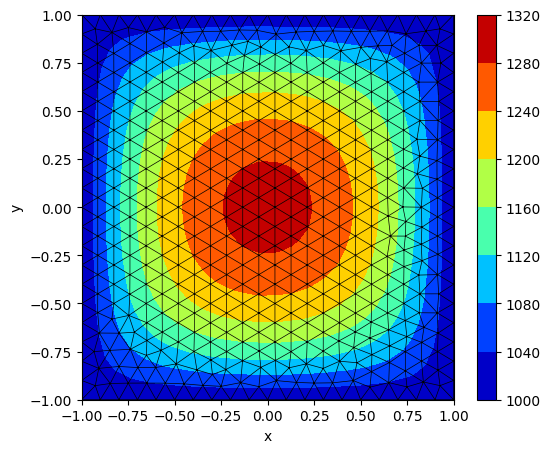

Solution at point <dolfin.cpp.geometry.Point object at 0x7eaae06b9970>: 1263.3179567734976


In [10]:
coordinates = mesh.coordinates()
values = u_sol.compute_vertex_values(mesh)
x, y = coordinates[:, 1], coordinates[:, 0]

triang = Triangulation(x, y, mesh.cells())
plt.figure(figsize=(6,5))

plt.tricontourf(triang, values, cmap='jet')
plt.colorbar()
plt.triplot(triang, 'k-', lw=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig(f'heat_2d', dpi=300, transparent=True); plt.show()

point = Point(0.25, 0.25)
u_value = u_sol(point)
print(f"Solution at point {point}: {u_value}")

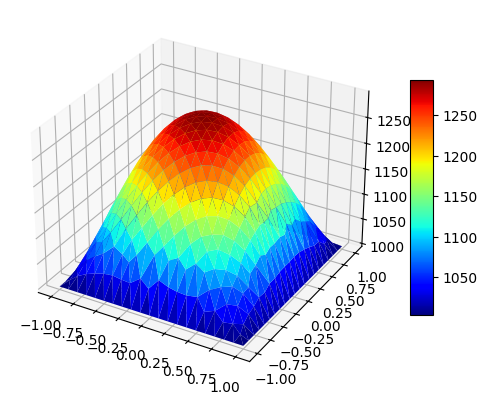

In [11]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

x, y, z = triang.x, triang.y, values

ax.plot_trisurf(x, y, z, triangles=triang.triangles, cmap='jet', edgecolor='none')

mappable = ax.collections[0]  # Extract the mappable object

plt.tight_layout()
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
plt.savefig('heat_3d', dpi=300, transparent=True)
plt.show()

In [12]:
print(u_sol([0.0, 0.0]))

1293.9374070898552


In [13]:
# !sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

!jupyter nbconvert --to latex FEniCS_Tutorial.ipynb

[NbConvertApp] WARNING | pattern 'FEniCS_Tutorial.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute